<a href="https://colab.research.google.com/github/sahanas0/LEGO_ErrorDetection/blob/main/LEGOErrorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/dataset.zip'

import zipfile

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')  # Extract to local Colab folder
print("✅ Dataset extracted from Drive.")


✅ Dataset extracted from Drive.


In [3]:
import os
print(os.listdir())  # List contents of the current working directory

['.config', 'dataset', 'drive', 'sample_data']


In [ ]:
#import shutil
#shutil.rmtree('dataset', ignore_errors=True)
#shutil.rmtree('dataset_split', ignore_errors=True)


In [4]:
import os

for root, dirs, files in os.walk('dataset'):
    print(f"{root} has {len(files)} files")


dataset has 0 files
dataset/dataset has 238 files
dataset/dataset/bad has 197 files
dataset/dataset/good has 197 files


In [5]:
!pip install imagehash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 3.8 MB/s eta 0:00:00


In [6]:
import imagehash
from PIL import Image
from collections import defaultdict

In [7]:
categories = ['bad', 'good']  # Define your categories

def remove_duplicates_by_hash(directory, threshold=0):
    """
    Removes duplicate or near-duplicate images within each category folder based on perceptual hash.
    Keeps only one copy.

    Args:
        directory (str): Path to dataset with category subfolders.
        threshold (int): Hamming distance threshold (0 = exact duplicate).
    """
    for category in categories:
        hash_dict = []
        category_path = os.path.join(directory, category)
        images = os.listdir(category_path)

        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img_hash = imagehash.average_hash(img)
            except Exception as e:
                print(f"❌ Failed to process {img_name}: {e}")
                continue

            # Check for duplicate within threshold
            duplicate_found = False
            for existing_hash, existing_path in hash_dict:
                if abs(existing_hash - img_hash) <= threshold:
                    duplicate_found = True
                    break

            if duplicate_found:
                os.remove(img_path)
                print(f"🗑️ Removed duplicate: {img_path}")
            else:
                hash_dict.append((img_hash, img_path))

    print("✅ Duplicate removal complete.")

# Call duplicate removal BEFORE splitting
remove_duplicates_by_hash(os.path.join('dataset', 'dataset'), threshold=0)

✅ Duplicate removal complete.


In [8]:
import os

for root, dirs, files in os.walk('dataset'):
    print(f"{root} has {len(files)} files")

dataset has 0 files
dataset/dataset has 238 files
dataset/dataset/bad has 197 files
dataset/dataset/good has 197 files


In [9]:
import os
import shutil
import random  # ✅ FIXED: Import random for shuffling

# STEP 2: Organize the dataset into train/test split using shutil
original_dir = 'dataset/dataset'
output_dir = 'dataset_split'
categories = ['bad', 'good']
train_ratio = 0.8

# Make new split folders
for split in ['train', 'test']:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Copy images into train/test folders
for category in categories:
    image_list = os.listdir(os.path.join(original_dir, category))
    random.shuffle(image_list)
    split_index = int(len(image_list) * train_ratio)
    train_images = image_list[:split_index]
    test_images = image_list[split_index:]

    for img in train_images:
        shutil.copyfile(os.path.join(original_dir, category, img),
                        os.path.join(output_dir, 'train', category, img))
    for img in test_images:
        shutil.copyfile(os.path.join(original_dir, category, img),
                        os.path.join(output_dir, 'test', category, img))

print("✅ Data split into train/test folders.")

# Optional: Check the file distribution
for root, dirs, files in os.walk("dataset_split"):
    print(f"{root} has {len(files)} files")


✅ Data split into train/test folders.
dataset_split has 0 files
dataset_split/test has 0 files
dataset_split/test/bad has 40 files
dataset_split/test/good has 40 files
dataset_split/train has 0 files
dataset_split/train/bad has 157 files
dataset_split/train/good has 157 files


In [10]:
from collections import Counter

train_images = []
test_images = []

for category in categories:
    train_path = os.path.join(output_dir, 'train', category)
    test_path = os.path.join(output_dir, 'test', category)
    train_images += [os.path.join('train', category, img) for img in os.listdir(train_path)]
    test_images += [os.path.join('test', category, img) for img in os.listdir(test_path)]

duplicates = set(train_images) & set(test_images)
print(f"Number of duplicates between train and test: {len(duplicates)}")


Number of duplicates between train and test: 0


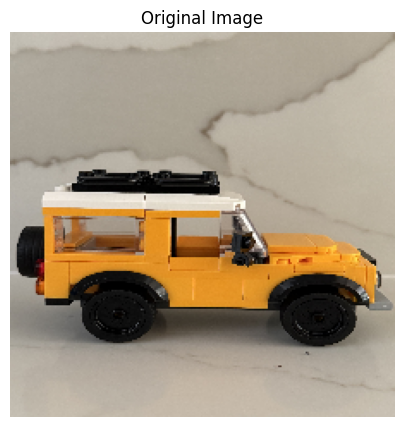

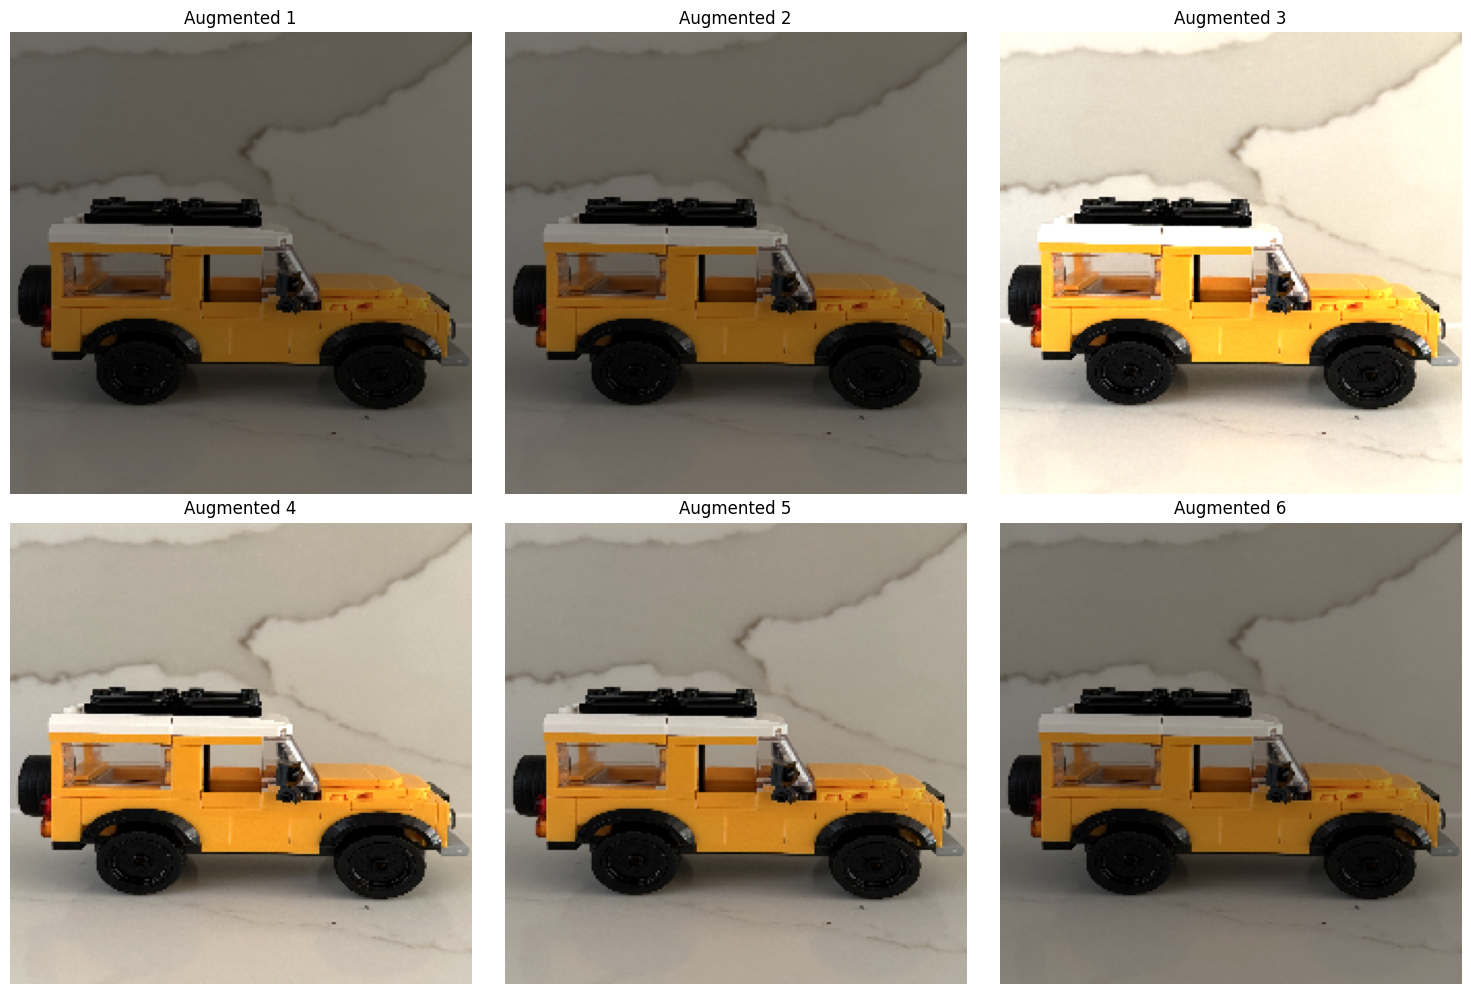

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf


# Set paths
IMG_SIZE = (224, 224)
DATA_ROOT = "dataset_split"
category = "good"  # Choose 'good' or 'bad' class
subset = "train"

# Load a sample image
sample_dir = os.path.join(DATA_ROOT, subset, category)
sample_image_name = os.listdir(sample_dir)[0]  # Pick the first image
sample_image_path = os.path.join(sample_dir, sample_image_name)

# Load and display original image
original_img = load_img(sample_image_path, target_size=IMG_SIZE)
plt.figure(figsize=(5,5))
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Convert to array for augmentation
x = img_to_array(original_img)
x = np.expand_dims(x, axis=0)

# Define your augmentation generator
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
   # rotation_range=40,
   # width_shift_range=0.3,
   # height_shift_range=0.3,
   # shear_range=0.3,
  #  zoom_range=0.4,
  #  horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Generate and display augmented images
aug_iter = datagen.flow(x, batch_size=1)

plt.figure(figsize=(15,10))
for i in range(6):  # Show 6 augmentations
    plt.subplot(2, 3, i+1)
    batch = next(aug_iter)
    img = batch[0]
    # Convert back to uint8 for visualization
    img = ((img + 1) * 127.5).astype(np.uint8)  # Reverse MobileNetV2 preprocessing
    plt.imshow(img)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2


Found 252 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
--- Starting initial training of the classification head (base model frozen) ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.5412 - loss: 3.1901 - val_accuracy: 0.5323 - val_loss: 2.5568
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8201 - loss: 2.1154 - val_accuracy: 0.5806 - val_loss: 2.1640
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9004 - loss: 1.6646 - val_accuracy: 0.6129 - val_loss: 1.8936
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9188 - loss: 1.3623 - val_accuracy: 0.6290 - val_loss: 1.6931
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9375 - loss: 1.1708 - val_accuracy: 0.6935 - val_loss: 1.5654
--- Initial training complete. Now starting fine-tuning ---
Fine-tuning for 15 additional epochs...
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.8647 - loss: 1.2001 - val_accuracy: 0.6452 - val_loss: 1.5660
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.8915 - loss: 1.1502 - val_accuracy: 0.6129 - val_loss: 1.5785
Epoch 7/20
16/16 ━━━━━━

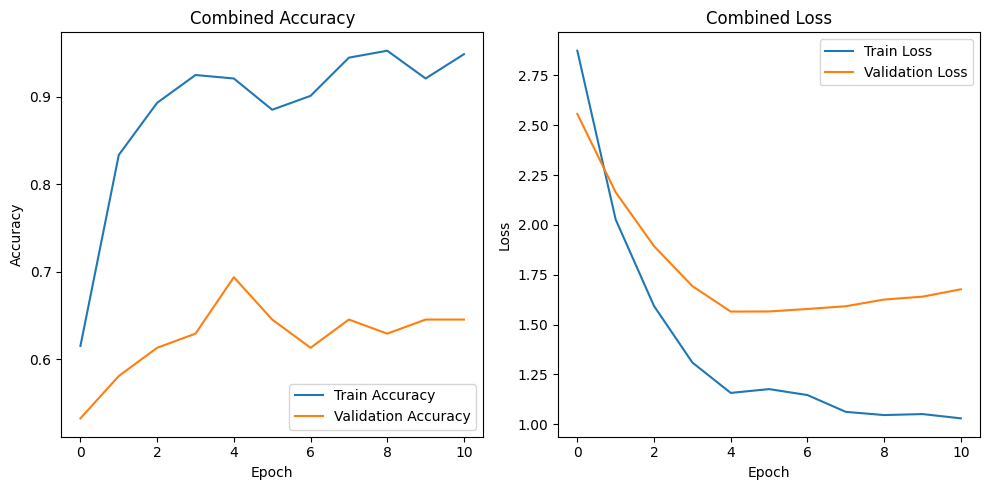


--- Evaluation on Validation Set (after fine-tuning) ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

Classification Report (Validation Set):
              precision    recall  f1-score   support

         bad       0.74      0.45      0.56        31
        good       0.60      0.84      0.70        31

    accuracy                           0.65        62
   macro avg       0.67      0.65      0.63        62
weighted avg       0.67      0.65      0.63        62



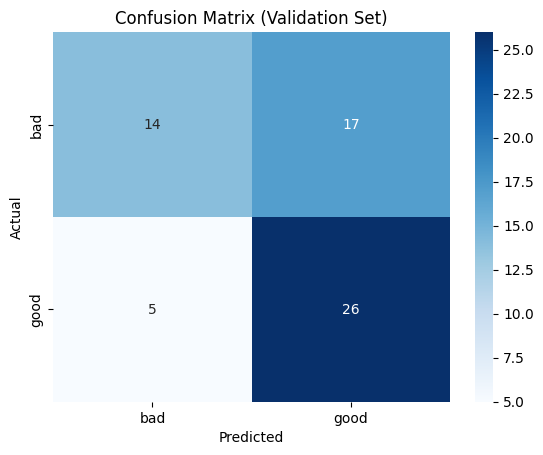

Accuracy (Validation Set): 0.6452
Precision (Validation Set): 0.6047
Recall (Validation Set): 0.8387
F1 Score (Validation Set): 0.7027
Found 80 images belonging to 2 classes.

--- Evaluating on the separate Test Set ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7592 - loss: 1.3926
Test Loss: 1.2270
Test Accuracy: 0.8375
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

Classification Report (Test Set):
              precision    recall  f1-score   support

         bad       0.94      0.72      0.82        40
        good       0.78      0.95      0.85        40

    accuracy                           0.84        80
   macro avg       0.86      0.84      0.84        80
weighted avg       0.86      0.84      0.84        80



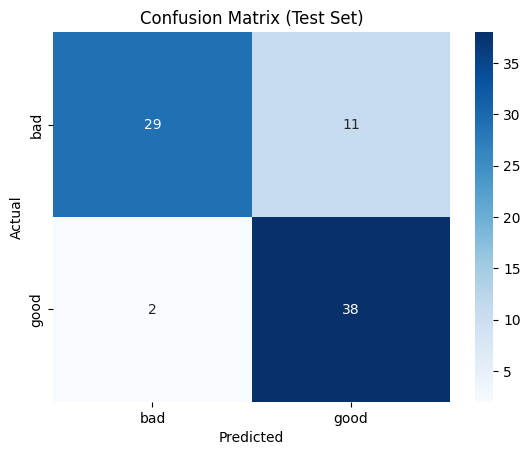

Accuracy (Test Set): 0.8375
Precision (Test Set): 0.7755
Recall (Test Set): 0.9500
F1 Score (Test Set): 0.8539
✅ Model and metrics complete.


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 5  # Initial epochs for training the head
DATA_ROOT = "dataset_split"

# ✅ ImageDataGenerator with Augmentation for Training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    # Uncomment and tune these for better augmentation!
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_ROOT, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_ROOT, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

# ✅ Build model with L2 regularization
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3))
base_model.trainable = False # Freeze the base model for initial training

inputs = Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# ✅ Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Increased patience

print("--- Starting initial training of the classification head (base model frozen) ---")
history = model.fit(
    train_gen,
    epochs=EPOCHS, # Use the initial EPOCHS value
    validation_data=val_gen,
    callbacks=[early_stop]
)

# Store initial training history for combined plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print("--- Initial training complete. Now starting fine-tuning ---")

# --- FINE-TUNING SECTION STARTS HERE ---

# Unfreeze the base model (or a portion of it)
# A common strategy is to unfreeze the last few convolutional blocks.
# MobileNetV2 has around 155 layers. You can check: print(len(base_model.layers))
# Unfreezing the last ~20-50 layers is a good starting point.
base_model.trainable = True

# Fine-tune from a specific layer onwards
# Let's unfreeze the last few blocks. You might need to experiment with this number.
# Example: unfreeze all layers from 'block_13_expand' onwards
# for layer in base_model.layers:
#    if layer.name == 'block_13_expand': # Adjust this based on MobileNetV2 layer names
#        layer.trainable = True
#    else:
#        layer.trainable = False
# A simpler approach is to unfreeze a certain number of layers from the end:
fine_tune_from_layer = 100 # Adjust this. E.g., unfreeze layers from index 100 onwards (out of ~155)
for layer in base_model.layers[:fine_tune_from_layer]:
    layer.trainable = False

# Recompile the model with a much lower learning rate for fine-tuning
# This is crucial to prevent large, disruptive updates to the pre-trained weights.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Very small learning rate
              loss="binary_crossentropy",
              metrics=["accuracy"])

fine_tune_epochs = 15 # Additional epochs for fine-tuning
total_epochs = EPOCHS + fine_tune_epochs # Total epochs for plotting

print(f"Fine-tuning for {fine_tune_epochs} additional epochs...")
history_fine_tune = model.fit(
    train_gen,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from where previous training left off
    validation_data=val_gen,
    callbacks=[early_stop] # Keep early stopping active
)

# Append fine-tuning history to initial history for combined plots
acc += history_fine_tune.history['accuracy']
val_acc += history_fine_tune.history['val_accuracy']
loss += history_fine_tune.history['loss']
val_loss += history_fine_tune.history['val_loss']

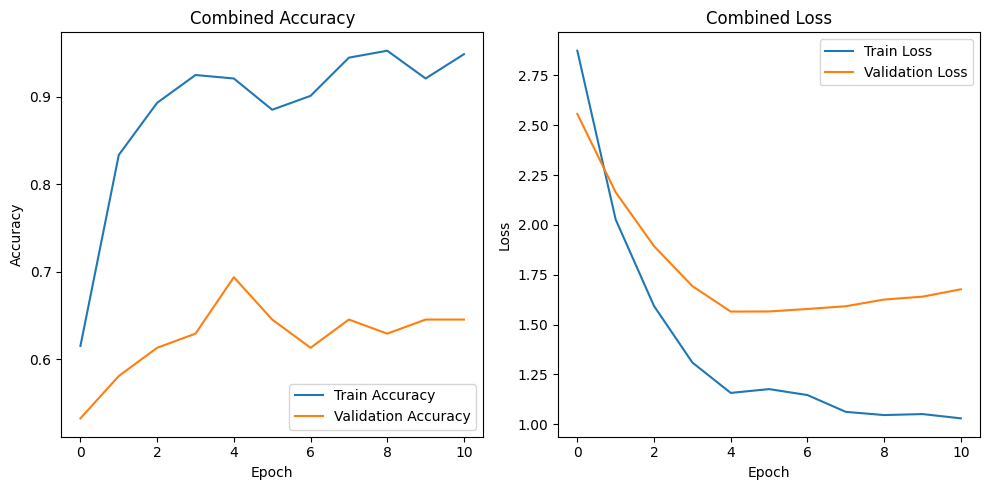


--- Evaluation on Validation Set (after fine-tuning) ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

Classification Report (Validation Set):
              precision    recall  f1-score   support

         bad       0.74      0.45      0.56        31
        good       0.60      0.84      0.70        31

    accuracy                           0.65        62
   macro avg       0.67      0.65      0.63        62
weighted avg       0.67      0.65      0.63        62



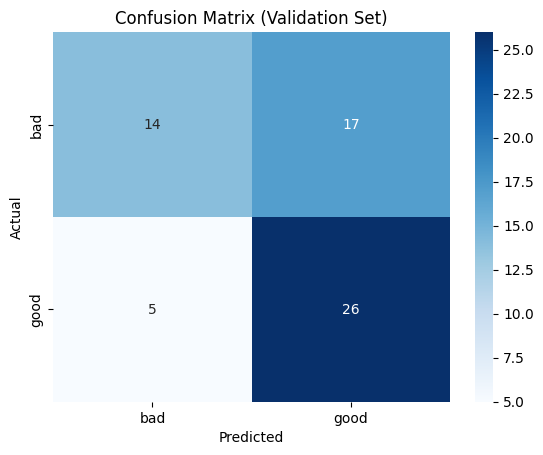

Accuracy (Validation Set): 0.6452
Precision (Validation Set): 0.6047
Recall (Validation Set): 0.8387
F1 Score (Validation Set): 0.7027
Found 80 images belonging to 2 classes.

--- Evaluating on the separate Test Set ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7592 - loss: 1.3926
Test Loss: 1.2270
Test Accuracy: 0.8375
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

Classification Report (Test Set) with threshold=0.7:
              precision    recall  f1-score   support

         bad       0.92      0.82      0.87        40
        good       0.84      0.93      0.88        40

    accuracy                           0.88        80
   macro avg       0.88      0.88      0.87        80
weighted avg       0.88      0.88      0.87        80


Classification Report (Test Set):
              precision    recall  f1-score   support

         bad       0.92      0.82      0.87        40
        good       0.84      0.93      0.88        40

    accuracy                           0.88        80
   macro avg       0.88      0.88      0.87        80
weighted avg       0.88      0.88      0.87        80



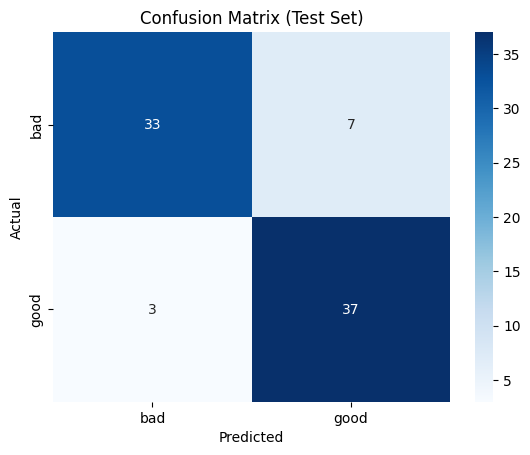

Accuracy (Test Set): 0.8750
Precision (Test Set): 0.8409


Recall (Test Set): 0.9250
F1 Score (Test Set): 0.8810
✅ Model and metrics complete.


In [17]:

# ✅ Plot accuracy and loss (for combined history)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(), plt.title('Combined Accuracy'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(), plt.title('Combined Loss'), plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# --- Evaluation on Validation Set (as before, but after fine-tuning) ---
print("\n--- Evaluation on Validation Set (after fine-tuning) ---")
val_preds = model.predict(val_gen)
y_pred = [int(p > 0.5) for p in val_preds.flatten()]
y_true = val_gen.classes

print("\nClassification Report (Validation Set):")
print(classification_report(y_true, y_pred, target_names=['bad', 'good']))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Accuracy (Validation Set): {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (Validation Set): {precision_score(y_true, y_pred):.4f}")
print(f"Recall (Validation Set): {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score (Validation Set): {f1_score(y_true, y_pred):.4f}")

# --- Add Evaluation on the separate Test Set (recommended for true performance) ---
# Create a generator for the 'test' set
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_ROOT, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False # Important for consistent evaluation
)

print("\n--- Evaluating on the separate Test Set ---")
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

test_preds = model.predict(test_gen)
y_pred_test = [int(p > 0.5) for p in test_preds.flatten()]
y_true_test = test_gen.classes
# After model.predict(test_gen)
test_preds = model.predict(test_gen)
# Experiment with different thresholds here
threshold = 0.7  # Start with 0.6, then try 0.65, 0.7
y_pred_test = [int(p > threshold) for p in test_preds.flatten()]
y_true_test = test_gen.classes

print(f"\nClassification Report (Test Set) with threshold={threshold}:")
print(classification_report(y_true_test, y_pred_test, target_names=['bad', 'good']))
# ... rest of your evaluation code ...


print("\nClassification Report (Test Set):")
print(classification_report(y_true_test, y_pred_test, target_names=['bad', 'good']))

cm_test = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Accuracy (Test Set): {accuracy_score(y_true_test, y_pred_test):.4f}")
print(f"Precision (Test Set): {precision_score(y_true_test, y_pred_test):.4f}")
print(f"Recall (Test Set): {recall_score(y_true_test, y_pred_test):.4f}")
print(f"F1 Score (Test Set): {f1_score(y_true_test, y_pred_test):.4f}")


# ✅ Save model
model.save("lego_error_model.h5")
print("✅ Model and metrics complete.")

In [18]:
from google.colab import files


Saving IMG_2713.jpg to IMG_2713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
✅ Prediction for IMG_2713.jpg: Good (no defect) (0.9954)


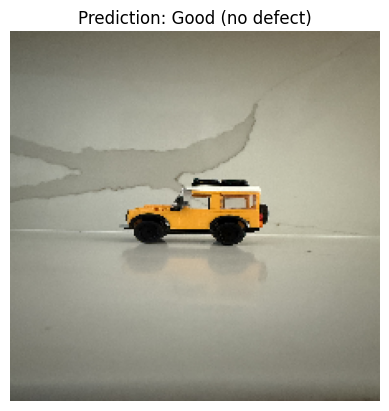

In [20]:
# ✅ Upload and predict a single image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Upload image
uploaded_file = files.upload()
for filename in uploaded_file.keys():
    # Load and preprocess image
    img_path = filename
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    prediction = model.predict(img_array)
    class_label = "Good (no defect)" if prediction[0][0] > 0.5 else "Bad (defective)"

    # Print results
    print(f"✅ Prediction for {filename}: {class_label} ({prediction[0][0]:.4f})")

    # Optional: Show image
    plt.imshow(img)
    plt.title(f"Prediction: {class_label}")
    plt.axis('off')
    plt.show()
